In [12]:
# ================================================
# 必要なライブラリのインポートと表示設定
# ================================================

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフ描画用ライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # 日付データを扱うための補助ツール
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフにする）

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa  # 時系列解析用のモジュール

# --------------------------------
# グラフの日本語表記設定
# --------------------------------
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"  # 日本語を「メイリオ」で表示

# --------------------------------
# DataFrame の全角文字（日本語など）の出力を整形
# --------------------------------
pd.set_option("display.unicode.east_asian_width", True)
# これにより、DataFrameを print したときに
# 全角文字がきれいに整列して表示される

In [2]:
# ================================================
# 表示設定（数値・DataFrame・グラフサイズ）
# ================================================

# NumPy の出力設定
# 配列を表示する際に「折り返し」を防ぎ、横幅を 80 文字に設定
np.set_printoptions(linewidth=80)

# pandas の出力設定
# DataFrame を表示する際に 1 行あたりの最大幅を 80 文字に設定
pd.set_option("display.width", 80)

# Matplotlib の設定
from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = (
    8,
    4,
)  # デフォルトのグラフサイズを幅8インチ × 高さ4インチに設定

In [3]:
# ================================================
# 飛行機乗客数データの読み込みと整形
# ================================================

# statsmodels に含まれるサンプルデータ "AirPassengers" を読み込み
# 1949年1月〜1960年12月の国際線乗客数（月次データ）
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスを作成
#   start='1949-01-01' : 開始日
#   periods=len(air_passengers) : データの行数分（144行 = 12年×12ヶ月）
#   freq='MS' : 月初（Month Start）をインデックスに指定
date_index = pd.date_range(start="1949-01-01", periods=len(air_passengers), freq="MS")

# 作成した日付インデックスを DataFrame に設定
air_passengers.index = date_index

# 不要な時間ラベルの削除
# データ読み込み時に最初の列（"time" ラベル）がついているため削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# データの先頭3行を確認
print(air_passengers.head(3))

            value
1949-01-01    112
1949-02-01    118
1949-03-01    132


<Axes: >

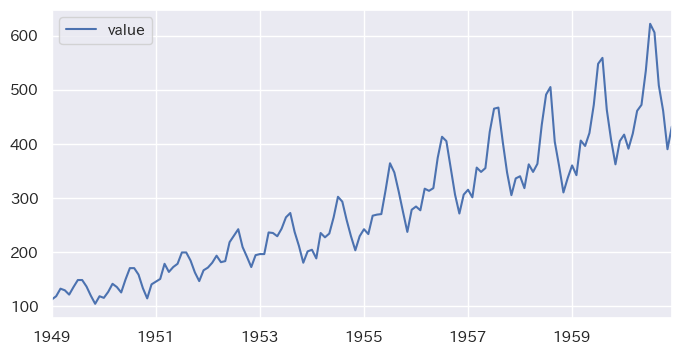

In [13]:
# 時系列折れ線グラフの作成
air_passengers.plot()

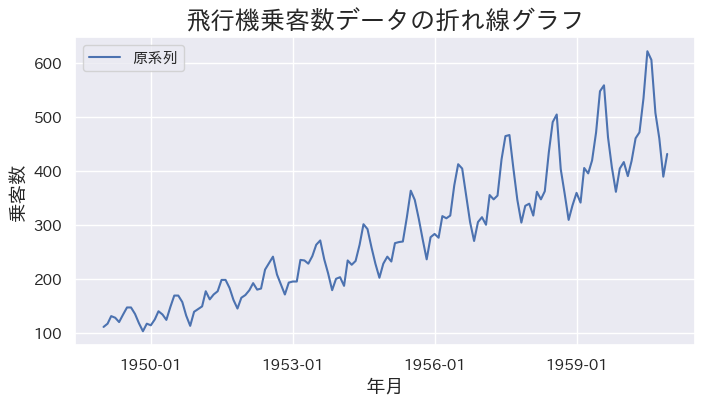

In [14]:
# ================================================
# 飛行機乗客数データの折れ線グラフの描画
# ================================================

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
#   'value' 列に月ごとの乗客数が入っている
ax.plot(air_passengers["value"], label="原系列")

# 軸ラベルとタイトル・凡例
ax.set_xlabel("年月", size=14)  # x軸ラベル
ax.set_ylabel("乗客数", size=14)  # y軸ラベル
ax.set_title("飛行機乗客数データの折れ線グラフ", size=18)  # グラフタイトル
ax.legend()  # 凡例の表示

# ---- x軸（年月）の設定 ----
# 3年ごとに目盛りを表示（1949, 1952, 1955, …）
ax.xaxis.set_major_locator(mdates.YearLocator(3))

# 軸ラベルのフォーマットを「YYYY-MM」に設定
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

In [15]:
# データをコピー（元のデータを壊さないように別の変数に複製する）
air_passengers_lag = air_passengers.copy()

# 1時点（1か月）前のデータを「lag1」列として追加
# shift(1) は行を下方向に1つずらす → t の行に t-1 の値が入る
# 時系列解析でラグ変数（遅れ変数）を作る典型的な方法
air_passengers_lag["lag1"] = air_passengers_lag["value"].shift(1)

# 結果の確認（最初の3行）
# → 先頭行には1つ前のデータが存在しないので NaN が入る
print(air_passengers_lag.head(3))

# 結果の確認（最後の3行）
# → 最後の行には1つ先のデータがないので value のみ表示され、lag1 は1つ前の値になる
print(air_passengers_lag.tail(3))

            value   lag1
1949-01-01    112    NaN
1949-02-01    118  112.0
1949-03-01    132  118.0
            value   lag1
1960-10-01    461  508.0
1960-11-01    390  461.0
1960-12-01    432  390.0


In [16]:
# 2時点前のデータを「lag2」列として追加
# shift(2) → t の行に t-2 の値が入る
# つまり2か月前の乗客数を特徴量として作成
air_passengers_lag["lag2"] = air_passengers_lag["value"].shift(2)

# 逆に未来のデータを参照する例として「lead1」列を追加
# shift(-1) → t の行に t+1 の値が入る
# つまり1か月後の乗客数を列として作成（通常は分析では使わないが確認用）
air_passengers_lag["lead1"] = air_passengers_lag["value"].shift(-1)

# 結果の確認（最初の3行）
# → lag2 は最初の2行が NaN, lead1 は未来が存在しないので最後の行が NaN
print(air_passengers_lag.head(3))

# 結果の確認（最後の3行）
# → lag1, lag2 は直前や2つ前の値が入る
# → lead1 は最後の行が NaN になる
print(air_passengers_lag.tail(3))

            value   lag1   lag2  lead1
1949-01-01    112    NaN    NaN  118.0
1949-02-01    118  112.0    NaN  132.0
1949-03-01    132  118.0  112.0  129.0
            value   lag1   lag2  lead1
1960-10-01    461  508.0  606.0  390.0
1960-11-01    390  461.0  508.0  432.0
1960-12-01    432  390.0  461.0    NaN


In [17]:
# 差分値の計算
# 時系列データの「非定常性」を取り除くためによく行う処理
# 差分 = 当月の値 - 前月の値
# （例：1月の値 - 前月12月の値）
diff_value = air_passengers_lag["value"] - air_passengers_lag["value"].shift(1)

# 先頭3行を表示
# → 1行目は前月が存在しないため NaN
# → 2行目以降は実際の差分値が表示される
diff_value.head(3)

1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
Freq: MS, Name: value, dtype: float64

In [18]:
# データをコピー
# 元のデータを直接書き換えないように、新しいDataFrameを作成する
air_passengers_diff = air_passengers.copy()

# 差分系列を計算
# .diff(1) は「1期前との差」を計算する（＝1階差分）
# 時系列のトレンドを取り除き、定常化に近づけるためによく用いられる手法
air_passengers_diff["diff1"] = air_passengers_diff["value"].diff(1)

# 結果の確認
# 先頭3行を表示（最初の行は前の値がないのでNaNになる）
print(air_passengers_diff.head(3))

# 末尾3行を表示（終盤の差分がどのような値になっているか確認）
print(air_passengers_diff.tail(3))

            value  diff1
1949-01-01    112    NaN
1949-02-01    118    6.0
1949-03-01    132   14.0
            value  diff1
1960-10-01    461  -47.0
1960-11-01    390  -71.0
1960-12-01    432   42.0


In [19]:
# 季節差分を計算
# .diff(12) は「12期前との差」を計算する
# 今回のデータは月次データなので「12ヶ月前との差」＝「前年同月との差分」となる
# 季節性（毎年繰り返されるパターン）を取り除くために利用される
air_passengers_diff["diff12"] = air_passengers_diff["value"].diff(12)

<Axes: >

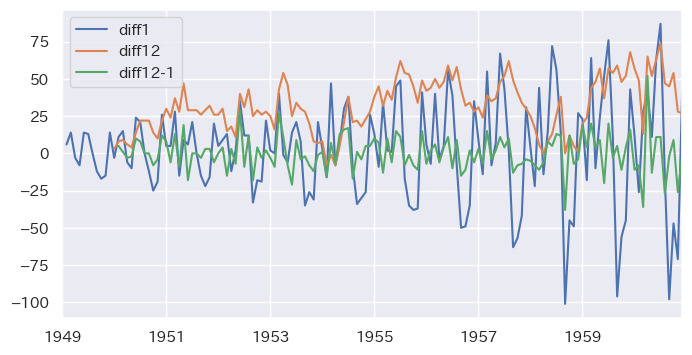

In [20]:
# 季節差分系列に対して、さらに1階差分をとる
# まず「12期前との差」（季節差分 diff12）を計算済み
# そこからさらに「1期前との差」を計算することで、季節性とトレンドの両方を取り除いた系列になる
# → ARIMAやSARIMAモデルの前処理でよく使われる
air_passengers_diff["diff12-1"] = air_passengers_diff["diff12"].diff(1)

# 時系列折れ線グラフを作成
# diff1     : 通常の1階差分（トレンド除去用）
# diff12    : 季節差分（前年同月との差）
# diff12-1  : 季節差分をさらに差分したもの（トレンド + 季節性を除去）
air_passengers_diff[["diff1", "diff12", "diff12-1"]].plot()

In [21]:
# 参考：差分をとる順番は関係ないことの確認
# diff12-1 : まず12期差分をとり、その後に1期差分をとったもの
# diff1-12 : まず1期差分をとり、その後に12期差分をとったもの
air_passengers_diff["diff1-12"] = air_passengers_diff["diff1"].diff(12)

# dropna() で NaN を除去した上で、両者が完全に一致するかをチェック
# True が返れば「差分の順番は関係ない」ということになる
all(
    air_passengers_diff["diff12-1"].dropna() == air_passengers_diff["diff1-12"].dropna()
)

True

<Axes: >

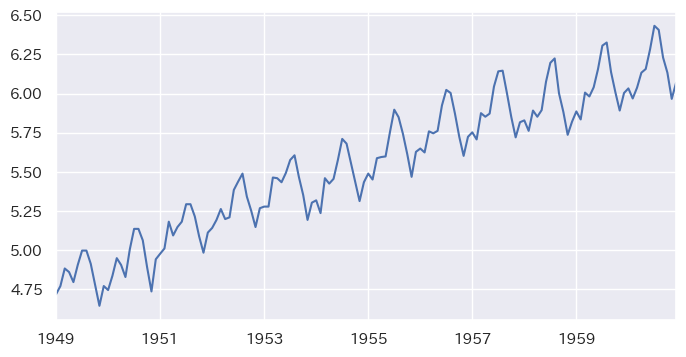

In [22]:
# データをコピー（元データを壊さないためにコピーを作成）
air_passengers_log = air_passengers.copy()

# 対数変換を行う
# - 時系列データでは、分散が大きくなる（変動幅が年月とともに大きくなる）ことが多い
# - 対数変換を使うと「変動の大きさを相対的に均一化」できる（分散安定化）
# - 予測モデル（ARIMAなど）においてもよく使われる前処理
air_passengers_log["log"] = air_passengers_log["value"].apply(np.log)

# 対数変換後の系列を折れ線グラフで描画
# 元の値と比較して「緩やかな右肩上がり」になることが確認できる
air_passengers_log["log"].plot()

In [23]:
# 対数変換をもとに戻す（逆変換）
# - np.exp は自然対数の逆関数（指数関数 e^x）
# - これにより対数変換前の元のスケールに戻せる
# - データの変換が正しく行われたか確認する際に使う
air_passengers_log["log"].apply(np.exp).head(3)

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
Freq: MS, Name: log, dtype: float64

In [24]:
# 対数差分系列の作成
# - 対数を取った値に対して、1期（1か月）前との差分を計算
# - これによりデータのトレンド（長期的な上昇傾向）が除去される
air_passengers_log["log_diff1"] = air_passengers_log["log"].diff(1)

# 対数季節差分系列の作成
# - 対数を取った値に対して、12期（1年）前との差分を計算
# - これにより季節性（毎年繰り返すパターン）が除去される
air_passengers_log["log_diff12"] = air_passengers_log["log"].diff(12)

<Axes: >

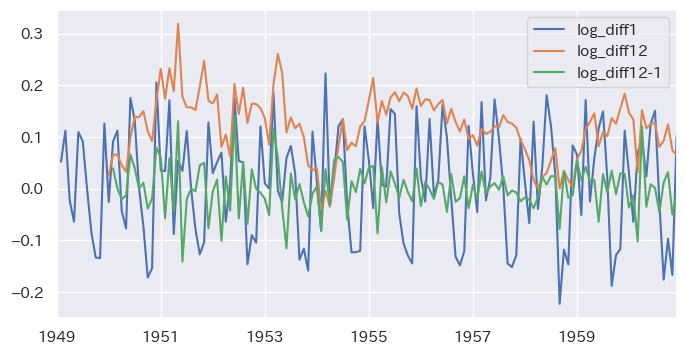

In [25]:
# 対数季節差分系列に対して、さらに通常の差分を取る
# - log_diff12: 季節性を除去した系列
# - その上で diff(1) を取ることで、残っているトレンド成分も除去
# - 「トレンド＋季節性」を取り除いた、より定常的な系列を得られる
air_passengers_log["log_diff12-1"] = air_passengers_log["log_diff12"].diff(1)

# 時系列折れ線グラフを描画
# - log_diff1: トレンドを除去した系列
# - log_diff12: 季節性を除去した系列
# - log_diff12-1: 季節性を除去した上でさらに差分を取り、定常性を高めた系列
air_passengers_log[["log_diff1", "log_diff12", "log_diff12-1"]].plot()

In [26]:
# 自己相関係数（Autocorrelation Function: ACF）の計算
# nlags=12 として、ラグ0からラグ12までの自己相関係数を算出する
# 自己相関係数は「時系列がどの程度自己相関を持つか（過去の値と現在の値がどの程度関係しているか）」を示す指標である
tsa.acf(air_passengers["value"], nlags=12)

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542, 0.71376997,
       0.6817336 , 0.66290439, 0.65561048, 0.67094833, 0.70271992, 0.74324019,
       0.76039504])

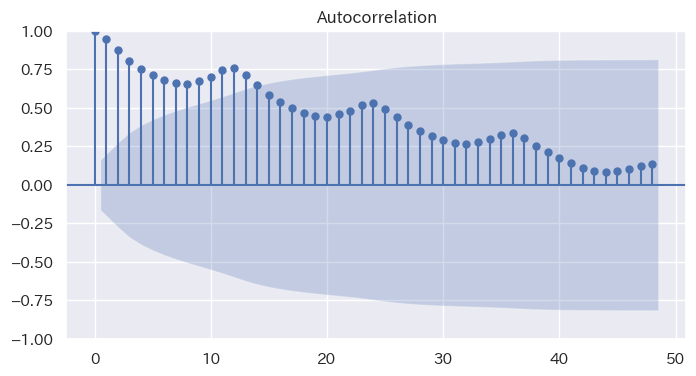

In [27]:
# コレログラム（自己相関関数のグラフ）の作成
# lags=48 として、ラグ0からラグ48までの自己相関係数を可視化する
# 縦の点線（青色の帯）は「有意水準の95%信頼区間」を表しており、
# 棒グラフがこの帯を超えている場合、そのラグで有意な自己相関があると判断できる
_ = sm.graphics.tsa.plot_acf(air_passengers["value"], lags=48)

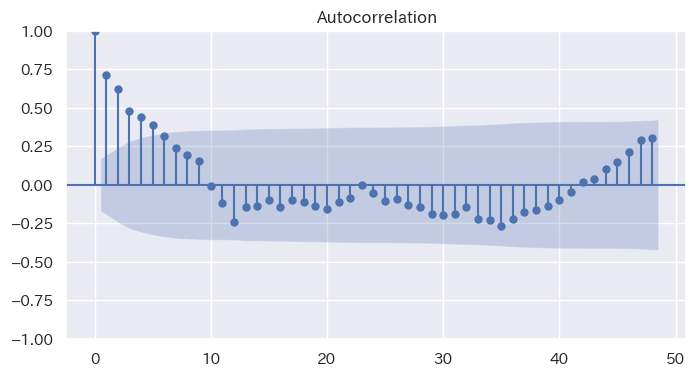

In [28]:
# 対数差分系列（12ヶ月の季節差分）のコレログラム
# dropna() で先頭の NaN を除去している
# lags=48 として、最大48ラグ先までの自己相関を表示する
# 季節差分を取ったため、元の系列に見られた強いトレンドや季節性は弱まり、
# より「定常的」な自己相関パターンを観察できる
_ = sm.graphics.tsa.plot_acf(air_passengers_log["log_diff12"].dropna(), lags=48)

<Axes: xlabel='value', ylabel='value'>

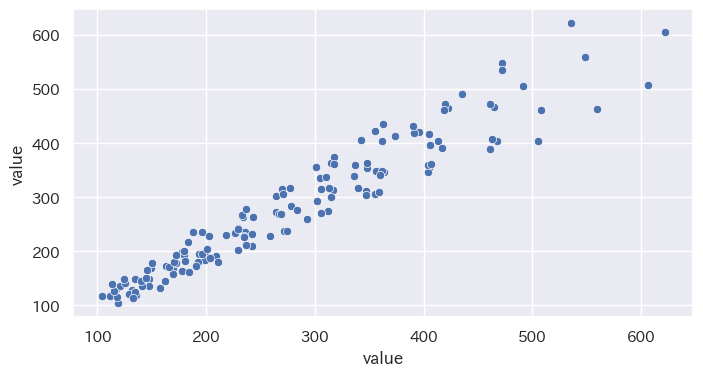

In [29]:
# 正の自己相関のイメージを可視化する散布図
# x軸には1期前（lag=1）の乗客数、y軸には当期の乗客数を配置する
# もし系列が強い正の自己相関を持つなら、点は右上がりの直線に近い分布になる
sns.scatterplot(
    x=air_passengers["value"].shift(1),  # 1期前の値
    y=air_passengers["value"],  # 現在の値
)

<Axes: xlabel='log_diff12', ylabel='log_diff12'>

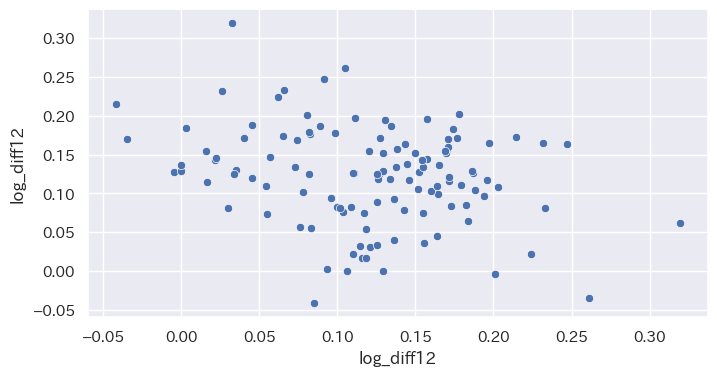

In [30]:
# 負の自己相関のイメージを可視化する散布図
# x軸には12期前（ラグ=12）の対数差分系列の値、
# y軸には当期の対数差分系列の値を配置する。
# 負の自己相関がある場合、点は右下がりの直線に近い分布を示す。
sns.scatterplot(
    x=air_passengers_log["log_diff12"].shift(12),  # 12期前の値
    y=air_passengers_log["log_diff12"],  # 現在の値
)

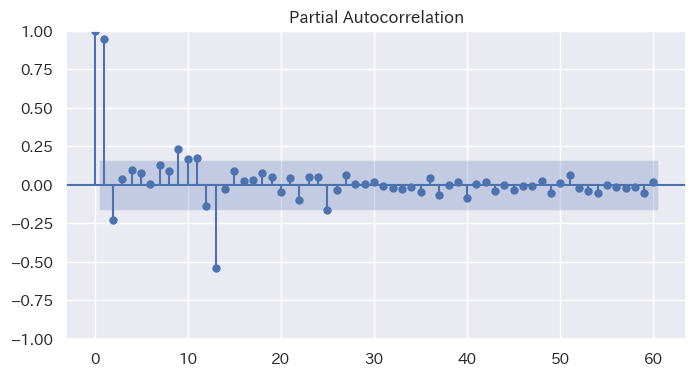

In [31]:
# 偏自己相関係数のコレログラム（Partial Autocorrelation Function: PACF）
# plot_pacfを使うと、あるラグにおける自己相関が、
# それ以前のラグの影響を取り除いた「純粋な相関」として計算される。
# - lags=60: 60期（60か月 = 5年間）までのラグを表示
# - method='ywm': Yule-Walker方程式に基づく推定方法を指定
_ = sm.graphics.tsa.plot_pacf(
    air_passengers["value"],  # 元データ
    lags=60,  # ラグの最大数
    method="ywm",  # 偏自己相関の推定方法
)

In [32]:
# データをコピー
air_passengers_ma = air_passengers.copy()
# → 元の飛行機乗客数データを複製して、新しいDataFrameに保存する。
#   （元データを上書きしないようにするため）

# 5時点の移動平均
air_passengers_ma["ma5"] = air_passengers_ma["value"].rolling(window=5).mean()
# → 「過去5期間（5か月）」のデータを使って平均を算出する。
#   例：5月の平均値は1月〜5月の平均。
#   → トレンドの滑らかな動きを捉える（短期変動を除去）。

# 5時点の移動平均において、当該時点を中心にする
air_passengers_ma["ma5_center"] = (
    air_passengers_ma["value"].rolling(window=5, center=True).mean()
)
# → 同じく5期間の移動平均だが、「中心」を現在の月に合わせて平均を計算する。
#   例：5月の平均値は3月〜7月の平均。
#   → よりトレンドを対称的に滑らかに表す。

# 結果の確認
print(air_passengers_ma.head(6))
# → 最初の6行を表示して、移動平均の計算結果を確認。
#   最初の数行は欠損値（NaN）になる（5期間分そろわないため）。

            value    ma5  ma5_center
1949-01-01    112    NaN         NaN
1949-02-01    118    NaN         NaN
1949-03-01    132    NaN       122.4
1949-04-01    129    NaN       127.0
1949-05-01    121  122.4       133.0
1949-06-01    135  127.0       136.2
